In [ ]:
import os, shutil
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import numpy as np
import torchvision.transforms.functional as TF
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from skimage.metrics import structural_similarity as compare_ssim
import glob
from multiprocessing import cpu_count
import json

In [ ]:
dataset_path = kagglehub.dataset_download("adwythdarsanr/gopro-image-deblurring-dataset")
gopro_root     = os.path.join(dataset_path, "Gopro")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Input directories for training data
train_blur  = os.path.join(gopro_root, "train", "blur")
train_sharp = os.path.join(gopro_root, "train", "sharp")

# Input directories for testing data
test_blur   = os.path.join(gopro_root, "test",  "blur")
test_sharp  = os.path.join(gopro_root, "test",  "sharp")

# Separate target directories for train and test
target_root   = "/content/gopro_full"
target_train_blur   = os.path.join(target_root, "train", "blur")
target_train_sharp  = os.path.join(target_root, "train", "sharp")
target_test_blur    = os.path.join(target_root, "test", "blur")
target_test_sharp   = os.path.join(target_root, "test", "sharp")

os.makedirs(target_train_blur, exist_ok=True)
os.makedirs(target_train_sharp, exist_ok=True)
os.makedirs(target_test_blur, exist_ok=True)
os.makedirs(target_test_sharp, exist_ok=True)

# Gather only training images
train_blur_images  = sorted(glob.glob(os.path.join(train_blur,  "*.png")))
train_sharp_images = sorted(glob.glob(os.path.join(train_sharp, "*.png")))
test_blur_images   = sorted(glob.glob(os.path.join(test_blur,   "*.png")))
test_sharp_images  = sorted(glob.glob(os.path.join(test_sharp,  "*.png")))


# Print dataset summary
print("Dataset summary")
print(f" → Training Blur  images : {len(train_blur_images)}")
print(f" → Training Sharp images : {len(train_sharp_images)}")
print(f" → Total training pairs  : {len(train_blur_images)}\n")
print(f" → Testing Blur  images  : {len(test_blur_images)}")
print(f" → Testing Sharp images : {len(test_sharp_images)}\n")

# Copy training images (train dataset)
for i in tqdm(range(len(train_blur_images)), desc="Copying training images"):
    shutil.copy(train_blur_images[i],  os.path.join(target_train_blur,  f"{i:05d}_blur.png"))
    shutil.copy(train_sharp_images[i], os.path.join(target_train_sharp, f"{i:05d}_sharp.png"))

# Copy testing images (test dataset)
for i in tqdm(range(len(test_blur_images)), desc="Copying testing images"):
    shutil.copy(test_blur_images[i],   os.path.join(target_test_blur,   f"{i:05d}_blur.png"))
    shutil.copy(test_sharp_images[i],  os.path.join(target_test_sharp,  f"{i:05d}_sharp.png"))

print(f"Copied training images to: {target_train_blur}, {target_train_sharp}")
print(f"Copied testing images to: {target_test_blur}, {target_test_sharp}")


Dataset summary
 → Training Blur  images : 2103
 → Training Sharp images : 2103
 → Total training pairs  : 2103

 → Testing Blur  images  : 1111
 → Testing Sharp images : 1111



Copying testing images: 100%|██████████| 1111/1111 [00:45<00:00, 24.21it/s]

Copied training images to: /content/gopro_full/train/blur, /content/gopro_full/train/sharp
Copied testing images to: /content/gopro_full/test/blur, /content/gopro_full/test/sharp


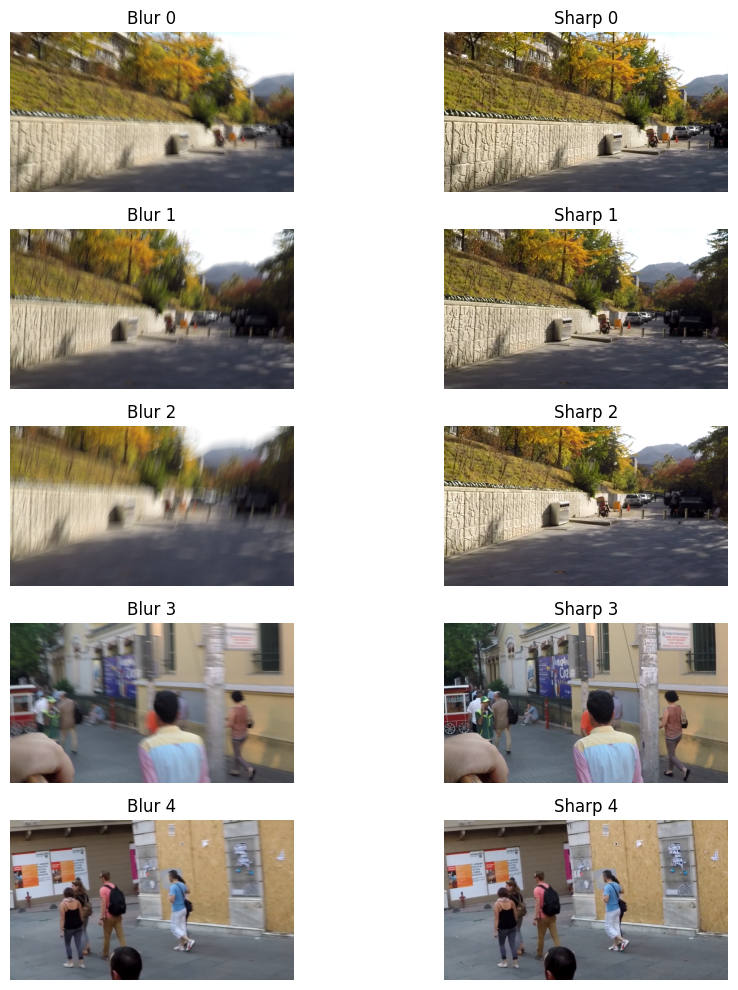

In [ ]:
# Visual check (first 5 pairs)
num_samples  = 5
plt.figure(figsize=(10, num_samples * 2))

train_blur_images = sorted(glob.glob(os.path.join(target_train_blur, "*.png")))
train_sharp_images = sorted(glob.glob(os.path.join(target_train_sharp, "*.png")))

# Visualize using the first 5 pairs of training data
for i in range(num_samples):
    b_img = Image.open(train_blur_images[i])
    s_img = Image.open(train_sharp_images[i])

    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(b_img); plt.title(f"Blur {i}");  plt.axis("off")

    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(s_img); plt.title(f"Sharp {i}"); plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from glob import glob
# Input directories for training and testing data
train_blur_dir = "/content/gopro_full/train/blur"   # Use train blur path
train_sharp_dir = "/content/gopro_full/train/sharp" # Use train sharp path
test_blur_dir = "/content/gopro_full/test/blur"     # Use test blur path
test_sharp_dir = "/content/gopro_full/test/sharp"   # Use test sharp path

# Output patch directories (separate for train and test)
patch_root = "/content/gopro_patches"
train_patch_blur = os.path.join(patch_root, "train", "blur")
train_patch_sharp = os.path.join(patch_root, "train", "sharp")
test_patch_blur = os.path.join(patch_root, "test", "blur")
test_patch_sharp = os.path.join(patch_root, "test", "sharp")

# Create necessary directories for patches
os.makedirs(train_patch_blur, exist_ok=True)
os.makedirs(train_patch_sharp, exist_ok=True)
os.makedirs(test_patch_blur, exist_ok=True)
os.makedirs(test_patch_sharp, exist_ok=True)

# Config for patch size and number of patches per image
patch_size = 100
patches_per_image = 10  # how many patches to extract per blur–sharp pair

# Load image pairs for train and test
train_blur_paths = sorted(glob(os.path.join(train_blur_dir, "*_blur.png")))
train_sharp_paths = sorted(glob(os.path.join(train_sharp_dir, "*_sharp.png")))
test_blur_paths = sorted(glob(os.path.join(test_blur_dir, "*_blur.png")))
test_sharp_paths = sorted(glob(os.path.join(test_sharp_dir, "*_sharp.png")))

assert len(train_blur_paths) == len(train_sharp_paths), "Mismatch in training image pair count!"
assert len(test_blur_paths) == len(test_sharp_paths), "Mismatch in testing image pair count!"

# Create patches for training dataset
patch_count = 0
for blur_path, sharp_path in tqdm(zip(train_blur_paths, train_sharp_paths), total=len(train_blur_paths), desc="Generating training patches"):
    blur_img = Image.open(blur_path).convert("RGB")
    sharp_img = Image.open(sharp_path).convert("RGB")

    w, h = blur_img.size

    for _ in range(patches_per_image):
        # Random top-left corner for crop
        left = random.randint(0, w - patch_size)
        top = random.randint(0, h - patch_size)
        right = left + patch_size
        bottom = top + patch_size

        # Crop both blur and sharp
        blur_patch = blur_img.crop((left, top, right, bottom))
        sharp_patch = sharp_img.crop((left, top, right, bottom))

        # Random horizontal and vertical flip
        if random.random() > 0.5:
            blur_patch = TF.hflip(blur_patch)
            sharp_patch = TF.hflip(sharp_patch)
        if random.random() > 0.5:
            blur_patch = TF.vflip(blur_patch)
            sharp_patch = TF.vflip(sharp_patch)

        angle = random.choice([0, 90, 180, 270])
        blur_patch = blur_patch.rotate(angle)
        sharp_patch = sharp_patch.rotate(angle)

        # Save patches for training set
        blur_patch.save(os.path.join(train_patch_blur, f"{patch_count:06d}_blur.png"))
        sharp_patch.save(os.path.join(train_patch_sharp, f"{patch_count:06d}_sharp.png"))
        patch_count += 1

# Create patches for testing dataset
for blur_path, sharp_path in tqdm(zip(test_blur_paths, test_sharp_paths), total=len(test_blur_paths), desc="Generating testing patches"):
    blur_img = Image.open(blur_path).convert("RGB")
    sharp_img = Image.open(sharp_path).convert("RGB")

    w, h = blur_img.size

    for _ in range(patches_per_image):
        # Random top-left corner for crop
        left = random.randint(0, w - patch_size)
        top = random.randint(0, h - patch_size)
        right = left + patch_size
        bottom = top + patch_size

        # Crop both blur and sharp
        blur_patch = blur_img.crop((left, top, right, bottom))
        sharp_patch = sharp_img.crop((left, top, right, bottom))

        # Random horizontal and vertical flip
        if random.random() > 0.5:
            blur_patch = TF.hflip(blur_patch)
            sharp_patch = TF.hflip(sharp_patch)
        if random.random() > 0.5:
            blur_patch = TF.vflip(blur_patch)
            sharp_patch = TF.vflip(sharp_patch)

        angle = random.choice([0, 90, 180, 270])
        blur_patch = blur_patch.rotate(angle)
        sharp_patch = sharp_patch.rotate(angle)

        # Save patches for testing set
        blur_patch.save(os.path.join(test_patch_blur, f"{patch_count:06d}_blur.png"))
        sharp_patch.save(os.path.join(test_patch_sharp, f"{patch_count:06d}_sharp.png"))
        patch_count += 1

print(f"Generated {patch_count} 100×100 patch pairs in: {patch_root}")


Generating testing patches: 100%|██████████| 1111/1111 [02:28<00:00,  7.46it/s]

Generated 32140 100×100 patch pairs in: /content/gopro_patches


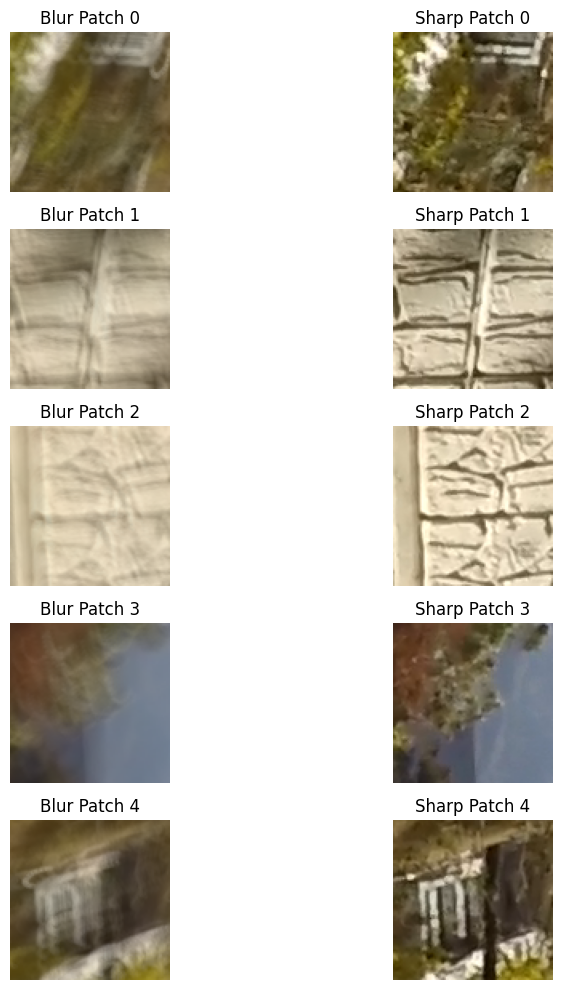

In [ ]:
# Load sample patch paths from the training directories
train_patch_blur = "/content/gopro_patches/train/blur"
train_patch_sharp = "/content/gopro_patches/train/sharp"

# Get first 5 patch pairs from training data
sample_blur_paths = sorted(glob(os.path.join(train_patch_blur, "*_blur.png")))[:5]
sample_sharp_paths = sorted(glob(os.path.join(train_patch_sharp, "*_sharp.png")))[:5]

# Plot them
plt.figure(figsize=(10, 10))
for i in range(len(sample_blur_paths)):
    blur_img = Image.open(sample_blur_paths[i])
    sharp_img = Image.open(sample_sharp_paths[i])

    # Blur patch
    plt.subplot(len(sample_blur_paths), 2, i*2 + 1)
    plt.imshow(blur_img)
    plt.title(f"Blur Patch {i}")
    plt.axis("off")

    # Sharp patch
    plt.subplot(len(sample_blur_paths), 2, i*2 + 2)
    plt.imshow(sharp_img)
    plt.title(f"Sharp Patch {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#Parameters
subset_size = 15000           #Set the subset size to 15,000
shuffle_data = True           # Shuffle dataset

source_blur_dir  = "/content/gopro_patches/train/blur"  # Use train blur path
source_sharp_dir = "/content/gopro_patches/train/sharp" # Use train sharp path

subset_blur_dir  = "/content/gopro_patches/train/blur_subset"
subset_sharp_dir = "/content/gopro_patches/train/sharp_subset"

# Create folders for the subset
os.makedirs(subset_blur_dir, exist_ok=True)
os.makedirs(subset_sharp_dir, exist_ok=True)

# Load and shuffle
all_blur_paths = sorted(glob(os.path.join(source_blur_dir, "*_blur.png")))
if shuffle_data:
    import random
    random.seed(42)
    random.shuffle(all_blur_paths)

# Copy the subset
copied = 0
print(f"Copying up to {subset_size} blur–sharp pairs from the training data to subset folders...")
for blur_path in all_blur_paths:
    fname = os.path.basename(blur_path)
    sharp_fname = fname.replace("_blur", "_sharp")
    sharp_path = os.path.join(source_sharp_dir, sharp_fname)

    if os.path.exists(sharp_path):  # copy if matching sharp exists
        shutil.copy(blur_path, os.path.join(subset_blur_dir, fname))
        shutil.copy(sharp_path, os.path.join(subset_sharp_dir, sharp_fname))
        copied += 1
        if copied >= subset_size:
            break

print(f"Subset created with {copied} pairs at:")
print(f" → {subset_blur_dir}")
print(f" → {subset_sharp_dir}")


Copying up to 15000 blur–sharp pairs from the training data to subset folders...
Subset created with 15000 pairs at:
 → /content/gopro_patches/train/blur_subset
 → /content/gopro_patches/train/sharp_subset


In [ ]:
!git clone https://github.com/swz30/Restormer.git
%cd Restormer

Cloning into 'Restormer'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 309 (delta 67), reused 56 (delta 56), pack-reused 202 (from 1)
Receiving objects: 100% (309/309), 1.56 MiB | 11.09 MiB/s, done.
Resolving deltas: 100% (123/123), done.
/content/Restormer


In [ ]:
# 1. Go to Restormer directory
%cd /content/Restormer

# 2. Create the folder path expected by demo.py
!mkdir -p Motion_Deblurring/pretrained_models

# 3. Download the pretrained weights
!wget -q https://github.com/swz30/Restormer/releases/download/v1.0/motion_deblurring.pth \
     -O Motion_Deblurring/pretrained_models/motion_deblurring.pth

print("✅ Weights downloaded")


/content/Restormer
✅ Weights downloaded


In [ ]:
'''DO NOT RUN WHEN DISCONNECTED-BACKUP FROM GDRIVE'''
# Run Restormer on this training subset to create teacher outputs
teacher_dir = "/content/teacher_outputs_subset"
os.makedirs(teacher_dir, exist_ok=True)

!python demo.py \
    --task Motion_Deblurring \
    --input_dir /content/gopro_patches/train/blur_subset \
    --result_dir /content/teacher_outputs_subset  # Store teacher outputs



 ==> Running Motion_Deblurring with weights Motion_Deblurring/pretrained_models/motion_deblurring.pth
 
100% 15000/15000 [15:08<00:00, 16.50it/s]

Restored images are saved at /content/teacher_outputs_subset/Motion_Deblurring


In [ ]:
# Move and rename teacher outputs
src_dir = "/content/teacher_outputs_subset/Motion_Deblurring"
dst_dir = "/content/teacher_outputs_subset"
os.makedirs(dst_dir, exist_ok=True)

for path in glob(os.path.join(src_dir, "*.png")):
    filename = os.path.basename(path)
    new_filename = filename.replace(".png", "_blur.png")
    shutil.move(path, os.path.join(dst_dir, new_filename))

print("Moved and renamed all teacher outputs to match expected format.")

# Rename files with '_blur_blur.png' to '_blur.png'
for fname in os.listdir(dst_dir):
    if fname.endswith("_blur_blur.png"):
        new_name = fname.replace("_blur_blur.png", "_blur.png")
        os.rename(
            os.path.join(dst_dir, fname),
            os.path.join(dst_dir, new_name)
        )

print("Renamed '_blur_blur.png' to '_blur.png'")

# Third Block: Verify dataset sizes
print("Blur subset :", len(glob(os.path.join(subset_blur_dir, "*.png"))))
print("Sharp subset:", len(glob(os.path.join(subset_sharp_dir, "*.png"))))
print("Teacher outs:", len(glob(os.path.join(teacher_dir, "*.png"))))


Moved and renamed all teacher outputs to match expected format.
Renamed '_blur_blur.png' to '_blur.png'
Blur subset : 15000
Sharp subset: 15000
Teacher outs: 15000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
'''DO NOT RUN WHEN DISCONNECTED-BACKUP FROM GDRIVE'''
# Remove existing backups before copying fresh ones
!rm -rf /content/drive/MyDrive/blur_subset_backup
!rm -rf /content/drive/MyDrive/sharp_subset_backup
!rm -rf /content/drive/MyDrive/teacher_outputs_subset_backup

!cp -r /content/gopro_patches/train/blur_subset /content/drive/MyDrive/blur_subset_backup
!cp -r /content/gopro_patches/train/sharp_subset /content/drive/MyDrive/sharp_subset_backup
!cp -r /content/teacher_outputs_subset /content/drive/MyDrive/teacher_outputs_subset_backup

print("Clean backup completed to Google Drive")

In [ ]:
'''RUN THIS WHEN DISCONNECTED-BACKUP'''

!mkdir -p /content/gopro_patches
!cp -r /content/drive/MyDrive/blur_subset_backup /content/gopro_patches/blur_subset
!cp -r /content/drive/MyDrive/sharp_subset_backup /content/gopro_patches/sharp_subset
!cp -r /content/drive/MyDrive/teacher_outputs_subset_backup /content/teacher_outputs_subset  # Updated for teacher outputs backup

print("All subsets restored from Google Drive")

# Directories for the subsets
subset_blur_dir  = "/content/gopro_patches/blur_subset"
subset_sharp_dir = "/content/gopro_patches/sharp_subset"
teacher_dir      = "/content/teacher_outputs_subset"

print(f"Total blur images   : {len(os.listdir(subset_blur_dir))}")
print(f"Total sharp images  : {len(os.listdir(subset_sharp_dir))}")
print(f"Total teacher images: {len(os.listdir(teacher_dir))}")


In [ ]:
# Dataset Class
class KDDataset(Dataset):
    def __init__(self, blur_dir, teacher_dir, sharp_dir):
        # Load all image paths
        self.blur_paths = sorted(glob.glob(os.path.join(blur_dir, "*.png")))
        self.teacher_dir = teacher_dir
        self.sharp_dir = sharp_dir

        # To convert images to float32
        self.to_float = T.ConvertImageDtype(torch.float32)

        # Prepare the triplet list (blur, teacher, sharp)
        self.triplets = []

        # Check each blur image and match with corresponding teacher and sharp images
        for b in self.blur_paths:
            fname = os.path.basename(b)

            t_path = os.path.join(teacher_dir, fname.replace("_blur", "_blur"))  # Adjusted for teacher format
            s_path = os.path.join(sharp_dir, fname.replace("_blur", "_sharp"))  # Sharp path

            # If both teacher and sharp images exist, add to the triplet list
            if os.path.exists(t_path) and os.path.exists(s_path):
                self.triplets.append((b, t_path, s_path))
            else:
                print(f"Missing: {t_path} or {s_path}")

        print(f"Total valid triplets found: {len(self.triplets)}")

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        b_path, t_path, s_path = self.triplets[idx]
        try:
            # Read the images and convert them to tensors
            blur    = TF.to_tensor(Image.open(b_path).convert("RGB"))
            teacher = TF.to_tensor(Image.open(t_path).convert("RGB"))
            sharp   = TF.to_tensor(Image.open(s_path).convert("RGB"))
        except FileNotFoundError:
            # Handle missing files
            print(f"Missing: {b_path}, {t_path}, {s_path}")
            return self.__getitem__((idx + 1) % len(self.triplets))

        # Convert to float32
        blur = self.to_float(blur)
        teacher = self.to_float(teacher)
        sharp = self.to_float(sharp)
        return blur, teacher, sharp

In [ ]:
import glob
# Set paths
subset_blur_dir  = "/content/gopro_patches/train/blur_subset"
subset_sharp_dir = "/content/gopro_patches/train/sharp_subset"
teacher_dir      = "/content/teacher_outputs_subset"

# Instantiate dataset
kd_dataset = KDDataset(subset_blur_dir, teacher_dir, subset_sharp_dir)

# Main DataLoader
kd_loader = DataLoader(
    kd_dataset,
    batch_size         = 4,
    shuffle            = True,
    num_workers        = min(2, cpu_count() // 2),
    pin_memory         = True,
    prefetch_factor    = 2,
    persistent_workers = True
)

test_loader = DataLoader(
    kd_dataset,
    batch_size  = 1,
    shuffle     = False,
    num_workers = 0
)

blur_b, teacher_b, sharp_b = next(iter(test_loader))
print("Sanity shapes:", blur_b.shape, teacher_b.shape, sharp_b.shape)

Total valid triplets found: 15000
Sanity shapes: torch.Size([1, 3, 100, 100]) torch.Size([1, 3, 100, 100]) torch.Size([1, 3, 100, 100])


First 10 teacher files:
 ['000000_blur.png', '000002_blur.png', '000004_blur.png', '000006_blur.png', '000007_blur.png', '000008_blur.png', '000010_blur.png', '000012_blur.png', '000014_blur.png', '000015_blur.png']
Using: 018779_blur.png
SSIM (Teacher vs GT): 0.9791


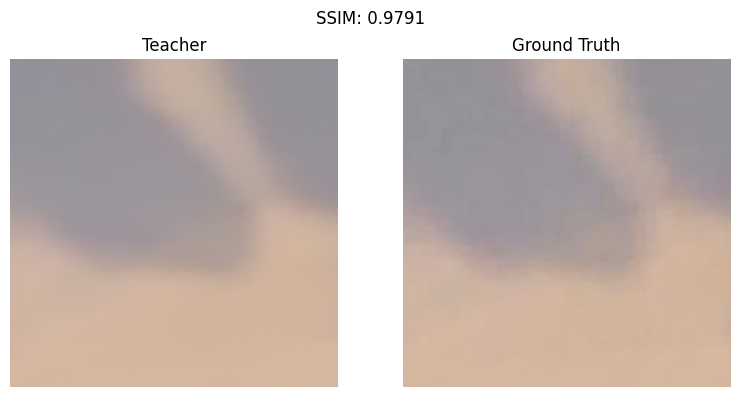

In [ ]:
teacher_dir = "/content/teacher_outputs_subset"
sharp_dir   = "/content/gopro_patches/train/sharp_subset"

teacher_files = sorted(os.listdir(teacher_dir))
print("First 10 teacher files:\n", teacher_files[:10])

example_name = random.choice(teacher_files)
print("Using:", example_name)

#Build matching sharp path
teacher_img_path = os.path.join(teacher_dir, example_name)
sharp_img_path   = os.path.join(sharp_dir, example_name.replace("_blur", "_sharp"))  # Adjust sharp file path

if not os.path.exists(sharp_img_path):
    print(f"Missing sharp image: {sharp_img_path}")
else:
    #Load images
    teacher_img = Image.open(teacher_img_path).convert("RGB")
    sharp_img   = Image.open(sharp_img_path).convert("RGB")

    #SSIM (for 100×100 RGB patches)
    teacher_np, sharp_np = np.array(teacher_img), np.array(sharp_img)
    ssim_score = compare_ssim(teacher_np, sharp_np, win_size=7, channel_axis=-1)
    print(f"SSIM (Teacher vs GT): {ssim_score:.4f}")

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(teacher_np); plt.title("Teacher"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(sharp_np);   plt.title("Ground Truth"); plt.axis("off")
    plt.suptitle(f"SSIM: {ssim_score:.4f}")
    plt.tight_layout(); plt.show()


In [ ]:
# Updated paths
teacher_dir = "/content/teacher_outputs_subset"  # Teacher images directory
sharp_dir   = "/content/gopro_patches/train/sharp_subset"  # Sharp images directory
cache_file  = "cached_teacher_ssim.json"  # Cache path for SSIM

if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        cached = json.load(f)
    avg_ssim = cached.get("avg_ssim", None)
    if avg_ssim:
        print(f"Loaded cached teacher SSIM: {avg_ssim:.4f}")
else:
    teacher_files = sorted(os.listdir(teacher_dir))
    assert teacher_files, "No teacher images found!"

    total_ssim = 0.0
    valid_imgs = 0

    # Loop through teacher images
    for fname in tqdm(teacher_files, desc="Computing SSIM"):
        if not fname.endswith(".png"):
            continue

        # Construct paths for teacher and sharp images
        t_path = os.path.join(teacher_dir, fname)
        s_path = os.path.join(sharp_dir, fname.replace("_blur", "_sharp"))

        # Check if sharp image exists
        if not os.path.exists(s_path):
            continue

        try:
            # Load images
            t_img = np.array(Image.open(t_path).convert("RGB"))
            s_img = np.array(Image.open(s_path).convert("RGB"))
        except Exception as e:
            print(f"Error loading images {t_path} or {s_path}: {e}")
            continue

        # Calculate SSIM
        total_ssim += compare_ssim(t_img, s_img, win_size=7, channel_axis=-1)
        valid_imgs += 1

    # Final SSIM calculation and caching
    if valid_imgs == 0:
        print("No valid images for SSIM computation!")
    else:
        avg_ssim = total_ssim / valid_imgs
        print(f"\nAverage SSIM of *teacher* on the subset: {avg_ssim:.4f}")

        # Save to cache
        with open(cache_file, "w") as f:
            json.dump({"avg_ssim": avg_ssim}, f)


Computing SSIM: 100%|██████████| 15001/15001 [00:50<00:00, 299.23it/s]


Average SSIM of *teacher* on the subset: 0.9029


In [ ]:
from torchvision import transforms
# basic transform to convert image to tensor and normalize
to_tensor = transforms.Compose([
    transforms.ToTensor(),  # Convert to [0, 1] float tensor
])

def load_tensor(img_path):
    if not os.path.exists(img_path):
        print(f"Path does not exist: {img_path}")
        return None

    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            return to_tensor(img)  # Convert to tensor
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

In [ ]:
# Main multi-worker loader
kd_loader = DataLoader(
    kd_dataset,
    batch_size     = 4,
    shuffle        = True,
    num_workers    = 2,
    pin_memory     = True
)

quick_loader = DataLoader(
    kd_dataset,
    batch_size  = 1,   # tiny batch
    shuffle     = False,
    num_workers = 0
)

blur_b, teacher_b, sharp_b = next(iter(quick_loader))
print(f"Sanity shapes: {blur_b.shape}, {teacher_b.shape}, {sharp_b.shape}")

Sanity shapes: torch.Size([1, 3, 100, 100]), torch.Size([1, 3, 100, 100]), torch.Size([1, 3, 100, 100])


In [ ]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [ ]:
!pip install pytorch-msssim

In [ ]:
import torch.nn as nn, torch.nn.functional as F
from torchvision import models, transforms as T
import piq

to_tensor = T.Compose([T.ToTensor()])

def load_tensor(path):
    try:
        img = Image.open(path).convert("RGB")
        return to_tensor(img)
    except Exception as e:
        print(f"{path}: {e}")
        return torch.zeros(3, 224, 224)

# Charbonnier loss
def charbonnier_loss(x, y, eps=1e-3):
    return torch.mean(torch.sqrt((x - y) ** 2 + eps ** 2))

# SSIM (multi-scale) loss
def ssim_loss(pred, sharp):
    # multi_scale_ssim returns 1×N values
    return 1 - piq.multi_scale_ssim(pred, sharp, data_range=1.).mean()

# VGG feature extractor & perceptual loss
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # future-proof weights API
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.features = nn.Sequential(*list(vgg.children())[:16])
        # freeze VGG params
        for p in self.parameters():
            p.requires_grad = False

        # transformation to ImageNet space
        self.norm = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def forward(self, x):
        return self.features(self.norm(x))

vgg_extractor = VGG16FeatureExtractor()

def perceptual_loss(pred, teacher):
    with torch.no_grad():
        t_feat = vgg_extractor(teacher)
    p_feat = vgg_extractor(pred)  # gradients flow through this branch
    return F.mse_loss(p_feat, t_feat)

# Composite loss
def comp_loss(pred, sharp, teacher,
              alpha=0.5, beta=0.3, gamma=0.2, lambda_perc=0.1):
    l_charb = charbonnier_loss(pred, sharp)
    l_mse   = F.mse_loss(pred, teacher)
    l_ssim  = ssim_loss(pred, sharp)
    l_perc  = perceptual_loss(pred, teacher)
    return (alpha * l_charb +
            beta  * l_mse   +
            gamma * l_ssim  +
            lambda_perc * l_perc)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 190MB/s]


In [ ]:
import os, torch, piq
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import save_image
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm

In [ ]:
blur_dir    = "/content/gopro_patches/train/blur_subset"
sharp_dir   = "/content/gopro_patches/train/sharp_subset"
teacher_dir = "/content/teacher_outputs_subset"

from glob import glob
blur_paths = sorted(glob(f"{blur_dir}/*.png"))
triplet_paths = []

for b in blur_paths:
    base = os.path.basename(b).replace("_blur.png", "")
    s = os.path.join(sharp_dir,   f"{base}_sharp.png")
    t = os.path.join(teacher_dir, f"{base}_blur.png")

    if os.path.exists(s) and os.path.exists(t):
        triplet_paths.append((b, s, t))
    else:
        print(f"Skipping missing pair: {s} or {t}")

assert triplet_paths, "No valid triplets found!"

print(f"Found {len(triplet_paths)} triplets.")

kd_dataset = KDTripletDataset(triplet_paths)
kd_loader  = DataLoader(
    kd_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

Found 15000 triplets.


In [ ]:
# Student UNet-Tiny KD Training Script

def load_tensor(path):
    try:
        img = Image.open(path).convert("RGB")
        return T.ToTensor()(img).float().clamp(0, 1)  # [0,1] range
    except Exception as e:
        print(f"{path}: {e}")
        return torch.zeros(3, 224, 224)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class DilatedConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, d=2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, d, dilation=d), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, d, dilation=d), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class StudentUNetTiny(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.enc1 = ConvBlock(3, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DilatedConvBlock(base*2, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec2 = ConvBlock(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec1 = ConvBlock(base*2, base)
        self.final = nn.Conv2d(base, 3, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1))
        return self.final(d1)

# dataset
class KDTripletDataset(Dataset):
    def __init__(self, triplet_paths):
        self.triplets = triplet_paths
    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx):
        b, s, t = self.triplets[idx]
        return (load_tensor(b), load_tensor(t), load_tensor(s), os.path.basename(b))

#  losses
def charbonnier(x, y, eps=1e-3):
    return torch.mean(torch.sqrt((x-y)**2 + eps**2))
def ssim_batch(pred, sharp):
    return piq.ssim(pred, sharp, data_range=1., reduction='mean')
# 🔧 Composite Loss
def comp_loss(pred, sharp, teacher, w_ssim=0.15, w_l1=0.60, w_perc=0.25):
    # Clamp all inputs to [0,1]
    pred   = pred.clamp(0, 1)
    sharp  = sharp.clamp(0, 1)
    teacher = teacher.clamp(0, 1)

    # Base losses
    l1  = F.l1_loss(pred, sharp)
    ssim = 1 - piq.ssim(pred, sharp, data_range=1.0, reduction='mean')
    perc = F.mse_loss(pred, teacher)

    return w_l1 * l1 + w_ssim * ssim + w_perc * perc

# training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = StudentUNetTiny().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-4)
sched  = ReduceLROnPlateau(opt, 'max', patience=3, factor=0.5)

save_best = "/content/best_student_model.pth"
ckpt_path = "/content/training_checkpoint.pth"
start_ep, best_ssim = 0, 0.0
if os.path.exists(ckpt_path):
    ck = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ck['model_state_dict'])
    opt.load_state_dict(ck['optimizer_state_dict'])
    start_ep, best_ssim = ck['epoch'], ck['best_ssim']
    print(f"Resumed from epoch {start_ep}")

# DataLoader
kd_loader = DataLoader(
    KDTripletDataset(triplet_paths),
    batch_size=4, shuffle=True, num_workers=0, pin_memory=True
)

os.makedirs("/content/student_outputs", exist_ok=True)

# training loop
for ep in range(start_ep, 100):
    model.train()
    tot_loss, tot_ssim, max_ssim = 0., 0., -1.
    for blur, teacher, sharp, names in tqdm(kd_loader, desc=f"Ep{ep+1}/100"):
        blur, teacher, sharp = [t.to(device) for t in (blur, teacher, sharp)]
        pred = model(blur)

        # save a few predictions for inspection
        for i, n in enumerate(names):
            save_image(pred[i].detach().cpu().clamp(0,1),
                       f"/content/student_outputs/{n.replace('_blur','_student_pred')}")

        loss = comp_loss(pred, sharp, teacher)
        opt.zero_grad(); loss.backward(); opt.step()
        tot_loss += loss.item()
        ssim_val = ssim_batch(pred.clamp(0,1), sharp.clamp(0,1)).item()
        tot_ssim += ssim_val; max_ssim = max(max_ssim, ssim_val)

    avg_loss = tot_loss / len(kd_loader)
    avg_ssim = tot_ssim / len(kd_loader)
    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
        torch.save(model.state_dict(), save_best)
        print(f"Saved best (SSIM {best_ssim:.4f})")

    sched.step(avg_ssim)
    print(f"Ep{ep+1}: loss={avg_loss:.4f}, SSIM={avg_ssim:.4f}, max={max_ssim:.4f}")

    torch.save({'epoch':ep+1,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':opt.state_dict(),
                'best_ssim':best_ssim}, ckpt_path)


Resumed from epoch 44


Ep45/100: 100%|██████████| 3750/3750 [02:21<00:00, 26.56it/s]


Saved best (SSIM 0.8329)
Ep45: loss=0.0425, SSIM=0.8329, max=0.9753


Ep46/100: 100%|██████████| 3750/3750 [02:21<00:00, 26.58it/s]


Saved best (SSIM 0.8335)
Ep46: loss=0.0423, SSIM=0.8335, max=0.9752


Ep47/100: 100%|██████████| 3750/3750 [02:21<00:00, 26.48it/s]


Saved best (SSIM 0.8340)
Ep47: loss=0.0422, SSIM=0.8340, max=0.9832


Ep48/100: 100%|██████████| 3750/3750 [02:20<00:00, 26.70it/s]


Saved best (SSIM 0.8345)
Ep48: loss=0.0421, SSIM=0.8345, max=0.9757


Ep49/100: 100%|██████████| 3750/3750 [02:20<00:00, 26.62it/s]


Saved best (SSIM 0.8351)
Ep49: loss=0.0420, SSIM=0.8351, max=0.9768


Ep50/100: 100%|██████████| 3750/3750 [02:20<00:00, 26.65it/s]


Saved best (SSIM 0.8356)
Ep50: loss=0.0418, SSIM=0.8356, max=0.9728


Ep51/100: 100%|██████████| 3750/3750 [02:20<00:00, 26.60it/s]


Saved best (SSIM 0.8361)
Ep51: loss=0.0417, SSIM=0.8361, max=0.9792


Ep52/100: 100%|██████████| 3750/3750 [02:20<00:00, 26.68it/s]


Saved best (SSIM 0.8365)
Ep52: loss=0.0416, SSIM=0.8365, max=0.9835


Ep53/100: 100%|██████████| 3750/3750 [02:21<00:00, 26.57it/s]


Saved best (SSIM 0.8371)
Ep53: loss=0.0415, SSIM=0.8371, max=0.9750


Ep54/100: 100%|██████████| 3750/3750 [02:21<00:00, 26.54it/s]


Saved best (SSIM 0.8375)
Ep54: loss=0.0414, SSIM=0.8375, max=0.9793


Ep55/100: 100%|██████████| 3750/3750 [02:21<00:00, 26.50it/s]


Saved best (SSIM 0.8379)
Ep55: loss=0.0413, SSIM=0.8379, max=0.9767


Ep56/100: 100%|██████████| 3750/3750 [02:23<00:00, 26.13it/s]


Saved best (SSIM 0.8384)
Ep56: loss=0.0412, SSIM=0.8384, max=0.9792


Ep57/100:  33%|███▎      | 1233/3750 [00:46<01:34, 26.50it/s]

#AVG SSIM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper: load tensor from image
def load_tensor(path):
    image = Image.open(path).convert("RGB")
    return T.ToTensor()(image).float().clamp(0, 1)

# Helper: compute SSIM between two images
def compute_ssim(img1, img2):
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)
    return piq.ssim(img1, img2, data_range=1.0).item()

# TRAINING SET SSIM (student_outputs vs train sharp)
train_sharp_dir = "/content/gopro_patches/train/sharp_subset"
train_student_dir = "/content/student_outputs"

train_sharp_map = {os.path.basename(p).split("_")[0]: p for p in glob(os.path.join(train_sharp_dir, "*.png"))}
train_pred_map  = {os.path.basename(p).split("_")[0]: p for p in glob(os.path.join(train_student_dir, "*_student_pred.png"))}

train_ssims = []
for key in sorted(set(train_sharp_map) & set(train_pred_map)):
    sharp = load_tensor(train_sharp_map[key])
    pred  = load_tensor(train_pred_map[key])
    ssim_val = compute_ssim(pred, sharp)
    train_ssims.append(ssim_val)

avg_train_ssim = sum(train_ssims) / len(train_ssims)
print(f"Average SSIM on Training Set: {avg_train_ssim:.4f}")

Average SSIM on Training Set: 0.8318


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_tensor(path):
    image = Image.open(path).convert("RGB")
    return T.ToTensor()(image).float().clamp(0, 1)

def compute_ssim(img1, img2):
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)
    return piq.ssim(img1, img2, data_range=1.0).item()

# Load trained model
model = StudentUNetTiny().to(device)
model.load_state_dict(torch.load("/content/best_student_model.pth", map_location=device))
model.eval()

# Predict on test set
test_blur_dir  = "/content/gopro_patches/test/blur"
test_sharp_dir = "/content/gopro_patches/test/sharp"
output_dir     = "/content/student_test_outputs"
os.makedirs(output_dir, exist_ok=True)

blur_paths  = sorted(glob(os.path.join(test_blur_dir, "*.png")))
sharp_paths = sorted(glob(os.path.join(test_sharp_dir, "*.png")))

ssim_scores = []
for blur_path, sharp_path in tqdm(zip(blur_paths, sharp_paths), total=len(blur_paths)):
    blur  = load_tensor(blur_path).unsqueeze(0).to(device)
    sharp = load_tensor(sharp_path)

    with torch.no_grad():
        pred = model(blur).squeeze(0).clamp(0, 1).cpu()

    # Save prediction
    fname = os.path.basename(blur_path).replace("_blur", "_student_pred")
    save_path = os.path.join(output_dir, fname)
    T.ToPILImage()(pred).save(save_path)

    # Compute SSIM
    ssim_val = compute_ssim(pred, sharp)
    ssim_scores.append(ssim_val)

# Final average SSIM
avg_test_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"Average SSIM on Test Set: {avg_test_ssim:.4f}")


100%|██████████| 11110/11110 [01:36<00:00, 114.65it/s]

Average SSIM on Test Set: 0.8072


In [ ]:
teacher_dir = "/content/teacher_outputs_test"
os.makedirs(teacher_dir, exist_ok=True)


!python demo.py \
    --task Motion_Deblurring \
    --input_dir /content/gopro_patches/test/blur \
    --result_dir /content/teacher_outputs_test


In [ ]:
# dirs
blur_dir    = "/content/gopro_patches/test/blur"
sharp_dir   = "/content/gopro_patches/test/sharp"
student_dir = "/content/student_test_outputs"
teacher_dir = "/content/teacher_outputs_test/Motion_Deblurring"  # teacher sub-folder

def map_by_id(folder, suffixes):
    d = {}
    for suff in suffixes:
        for p in glob(os.path.join(folder, f"*{suff}")):
            d[os.path.basename(p).replace(suff, "")] = p
    return d

blur_map    = map_by_id(blur_dir,    ["_blur.png"])
sharp_map   = map_by_id(sharp_dir,   ["_sharp.png"])
student_map = map_by_id(student_dir, ["_student_pred.png"])
teacher_map = map_by_id(teacher_dir, ["_blur_restored.png", "_restored.png", "_blur.png"])

common_ids = sorted(set(blur_map) & set(sharp_map) & set(student_map) & set(teacher_map))
print(f" Visualizable samples found: {len(common_ids)}")

n_show = 12
for key in random.sample(common_ids, min(n_show, len(common_ids))):

    with Image.open(blur_map[key])    as blur, \
         Image.open(student_map[key]) as student, \
         Image.open(teacher_map[key]) as teacher, \
         Image.open(sharp_map[key])   as sharp:

        fig, axes = plt.subplots(1, 4, figsize=(16,4))
        for ax, img, title in zip(
            axes,
            [blur, student, teacher, sharp],
            ["Blur (Input)", "Student", "Teacher", "Sharp GT"]
        ):
            ax.imshow(img); ax.set_title(title); ax.axis("off")

        plt.suptitle(f"Sample ID: {key}", fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

In [ ]:
# Average SSIM on FULL test images
import os
from glob import glob
from PIL import Image
import torch, piq
import torchvision.transforms as T
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_tensor(path):
    return T.ToTensor()(Image.open(path).convert("RGB")).float().clamp(0, 1)

def compute_ssim(a, b):
    return piq.ssim(a.unsqueeze(0).to(device), b.unsqueeze(0).to(device), data_range=1.0).item()

# Load trained student model
model = StudentUNetTiny().to(device)
model.load_state_dict(torch.load("/content/best_student_model.pth", map_location=device))
model.eval()

# Full-image folders
blur_dir   = "/content/gopro_full/test/blur"
sharp_dir  = "/content/gopro_full/test/sharp"
save_dir   = "/content/student_full_test_outputs"
os.makedirs(save_dir, exist_ok=True)

blur_files  = sorted(glob(os.path.join(blur_dir,  "*.png")))
sharp_files = sorted(glob(os.path.join(sharp_dir, "*.png")))
assert len(blur_files) == len(sharp_files), "Mismatch blur vs sharp count!"

ssim_vals = []
for b_path, s_path in tqdm(zip(blur_files, sharp_files), total=len(blur_files), desc="Full-img SSIM"):
    blur  = load_tensor(b_path).unsqueeze(0).to(device)
    sharp = load_tensor(s_path)

    with torch.no_grad():
        pred = model(blur).squeeze(0).clamp(0, 1).cpu()

    # save prediction
    out_name = os.path.basename(b_path).replace("_blur", "_student_pred")
    T.ToPILImage()(pred).save(os.path.join(save_dir, out_name))

    # SSIM
    ssim_vals.append(compute_ssim(pred, sharp))

avg_full_ssim = sum(ssim_vals) / len(ssim_vals)
print(f"Average SSIM (full images): {avg_full_ssim:.4f}")


In [ ]:
# dirs
blur_dir    = "/content/gopro_full/test/blur"
student_dir = "/content/student_full_test_outputs"
sharp_dir   = "/content/gopro_full/test/sharp"
save_vis_dir = "/content/full_test_vis"
os.makedirs(save_vis_dir, exist_ok=True)

def id_map(folder, suffix):
    return {os.path.basename(p).replace(suffix, ""): p
            for p in glob(os.path.join(folder, f"*{suffix}"))}

blur_map    = id_map(blur_dir,    "_blur.png")
student_map = id_map(student_dir, "_student_pred.png")
sharp_map   = id_map(sharp_dir,   "_sharp.png")

common_ids = sorted(set(blur_map) & set(student_map) & set(sharp_map))
print(f"Visualizable full-test samples: {len(common_ids)}")

n_show = 6
for key in random.sample(common_ids, n_show):
    with Image.open(blur_map[key]) as blur, \
         Image.open(student_map[key]) as student, \
         Image.open(sharp_map[key]) as sharp:

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for ax, img, lbl in zip(
            axes,
            [blur, student, sharp],
            ["Blur Input", "Student Output", "Sharp GT"]
        ):
            ax.imshow(img); ax.set_title(lbl); ax.axis("off")

        plt.suptitle(f"Full Image ID: {key}", fontsize=14)
        plt.tight_layout()

        if save_vis_dir:
            out_path = os.path.join(save_vis_dir, f"{key}_grid.png")
            fig.savefig(out_path, dpi=200)
            print(f"saved {out_path}")

        plt.show()
        plt.close(fig)

In [ ]:
'''# Define paths to test images
blur_dir = "/content/gopro_full/test/blur"
sharp_dir = "/content/gopro_full/test/sharp"

blur_images = sorted(glob(os.path.join(blur_dir, "*_blur.png")))
sharp_images = sorted(glob(os.path.join(sharp_dir, "*_sharp.png")))

assert len(blur_images) == len(sharp_images), "Mismatch in test blur/sharp image counts."

def load_gray_np(image_path):
    return np.array(Image.open(image_path).convert("L"))

# Compute SSIM between each blur-sharp pair
ssim_scores = []
for blur_path, sharp_path in tqdm(zip(blur_images, sharp_images), total=len(blur_images), desc="Computing SSIM"):
    blur = load_gray_np(blur_path)
    sharp = load_gray_np(sharp_path)

    score = compare_ssim(blur, sharp, data_range=255)
    ssim_scores.append(score)

# Average SSIM
avg_ssim = np.mean(ssim_scores)
print(f"\nBaseline SSIM (Blur vs Sharp): {avg_ssim:.4f}")

Computing SSIM: 100%|██████████| 1111/1111 [03:39<00:00,  5.06it/s]
📊 Baseline SSIM (Blur vs Sharp): 0.7732
'''

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedStudentUNetTiny().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

save_path       = "/content/best_student_model.pth"
checkpoint_path = "/content/training_checkpoint.pth"
from glob import glob
import os

# Adjust these to your actual dataset paths
blur_dir = "/content/train_blur"
teacher_dir = "/content/teacher_outputs"
sharp_dir = "/content/train_sharp"

# Gather all blur paths (assumes filenames are aligned)
blur_paths = sorted(glob(os.path.join(blur_dir, "*.png")))

triplet_paths = []
for blur_path in sorted(glob(os.path.join(blur_dir, "*.png"))):
    fname = os.path.basename(blur_path)
    sharp_path = os.path.join(sharp_dir, fname.replace("_blur", "_sharp"))
    teacher_path = os.path.join(teacher_dir, fname.replace("_blur", "_teacher"))

    if os.path.exists(sharp_path) and os.path.exists(teacher_path):
        triplet_paths.append((blur_path, teacher_path, sharp_path))


start_epoch, best_ssim = 0, 0.0
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    start_epoch, best_ssim = ckpt['epoch'], ckpt['best_ssim']
    print(f"Resuming from epoch {start_epoch+1}")

kd_loader = DataLoader(
    KDTripletDataset(triplet_paths),
    batch_size=4, shuffle=True, num_workers=2, pin_memory=True
)

os.makedirs("/content/student_outputs", exist_ok=True)

In [ ]:
def charbonnier_loss(x, y, eps=1e-3):
    return torch.mean(torch.sqrt((x - y)**2 + eps**2))

def ssim_batch(pred, sharp):
    return piq.ssim(pred, sharp, data_range=1.0, reduction='mean')

def ssim_loss(pred, sharp):  # for completeness
    return 1 - ssim_batch(pred, sharp)

def comp_loss(pred, sharp, teacher):
    return (
        0.5 * charbonnier_loss(pred, sharp) +
        0.3 * F.mse_loss(pred, teacher)     +
        0.2 * ssim_loss(pred, sharp)
    )


In [ ]:
# image to tensor helper
def load_tensor(path):
    try:
        img = Image.open(path).convert("RGB")
        return T.ToTensor()(img).float().clamp(0, 1)
    except Exception as e:
        print(f"{path}: {e}")
        return torch.zeros(3, 224, 224)
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double(x)

class DilatedConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilation=2):
        super().__init__()
        self.dilated = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.dilated(x)

class ImprovedStudentUNetTiny(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.enc1 = ConvBlock(3, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DilatedConvBlock(base*2, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = ConvBlock(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = ConvBlock(base*2, base)
        self.final = nn.Conv2d(base, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)
class KDTripletDataset(Dataset):
    def __init__(self, triplet_paths, transform=None):
        self.triplets = triplet_paths
        self.transform = transform

    def __len__(self): return len(self.triplets)

    def __getitem__(self, idx):
        blur_p, sharp_p, teach_p = self.triplets[idx]
        blur, sharp, teacher = map(load_tensor, (blur_p, sharp_p, teach_p))
        if self.transform:
            blur, sharp, teacher = map(self.transform, (blur, sharp, teacher))
        return blur, teacher, sharp, os.path.basename(blur_p)


In [ ]:
import piq

# Utility: SSIM for a batch
def ssim_batch(pred: torch.Tensor, sharp: torch.Tensor) -> torch.Tensor:
    """
    Computes mean SSIM over a batch. Returns a scalar in [0, 1].

    pred, sharp  : BCHW tensors in any dtype; will be converted to float32.
    """
    # Ensure same shape
    assert pred.shape == sharp.shape, "pred and sharp must have the same shape"

    pred  = torch.clamp(pred.float(),  0., 1.)
    sharp = torch.clamp(sharp.float(), 0., 1.)

    # piq.ssim → returns B-element tensor when reduction='none'
    ssim_vals = piq.ssim(pred, sharp, data_range=1.0, reduction='none')
    return ssim_vals.mean()            # scalar tensor

# Loss wrapper  (1 − SSIM)
def ssim_loss(pred: torch.Tensor, sharp: torch.Tensor) -> torch.Tensor:
    """
    Differentiable SSIM loss = 1 – SSIM.
    Suitable for back-prop / gradient descent.
    """
    pred  = torch.clamp(pred.float(),  0., 1.)
    sharp = torch.clamp(sharp.float(), 0., 1.)

    ssim_mean = piq.ssim(pred, sharp, data_range=1.0, reduction='mean')
    return 1.0 - ssim_mean